In [1]:
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
num_classes=4
num_features=2
random_seed=42

# create mutliclass datasets

X_blob,y_blob=make_blobs(n_samples=1000,
                         n_features=num_features,
                         centers=num_classes,
                         cluster_std=2,
                         random_state=random_seed)

#Turn data into tensors
X_blob= torch.from_numpy(X_blob).type(torch.float)
y_blob= torch.from_numpy(y_blob).type(torch.LongTensor)

print(X_blob.shape)
print(y_blob.shape)

torch.Size([1000, 2])
torch.Size([1000])


torch.Size([800, 2])
tensor([0, 1, 2, 3])


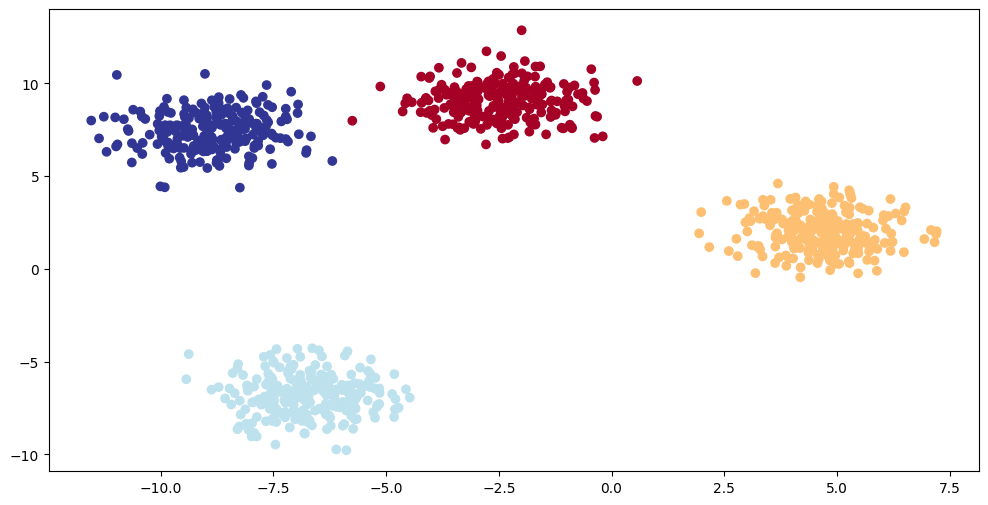

In [3]:
#Split

X_train,X_test,y_train,y_test=train_test_split(X_blob,y_blob, test_size=0.2, random_state=random_seed)

print(X_train.shape)
print(torch.unique(y_train))

# plot data 
plt.figure(figsize=(12,6))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap= plt.cm.RdYlBu)

In [4]:
## Make the model

device= "cuda" if torch.cuda.is_available() else 'cpu'
# device= "cpu"

class BlobModel(nn.Module):
    def __init__ (self, input, output):
        super(). __init__()

        self.layer=nn.Sequential(
            nn.Linear(in_features=input, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=output),
        )

    def forward(self,x):
        return self.layer(x)

model_1=BlobModel(num_features,num_classes).to(device)        

In [5]:
## Create accuracy funtion

def accuracy(y_true, y_pred):
    correct= torch.eq(y_true,y_pred).sum().item()
    acc= (correct/len(y_pred))*100
    return acc
    

In [6]:
## Creating loss function

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [7]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train,y_train = X_train.to(device), y_train.to(device)
X_test, y_test= X_test.to(device), y_test.to(device)

epochs=1000

for epoch in range (epochs):
    ### Training ###
    model_1.train()

    y_logits=model_1(X_train)
    y_preds=torch.softmax(y_logits,dim=1).argmax(dim=1)

    loss=loss_fn(y_logits,y_train)
    acc= accuracy(y_train,y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing ###
    model_1.eval()
    with torch.inference_mode():
        y_test_logits=model_1(X_test)
        y_test_preds=torch.softmax(y_test_logits, dim=1).argmax(dim=1)

        test_loss= loss_fn(y_test_logits,y_test)
        test_acc=accuracy(y_test, y_test_preds)
        
    if epoch % 100 ==0:
        print(f"|Epochs : {epoch} | Loss : {loss:.4f}  Train_Acc: {acc:.2f}% | Test_loss : {test_loss:.4f}  Test_Acc : {test_acc:.2f}% | ")


|Epochs : 0 | Loss : 1.3891  Train_Acc: 24.62% | Test_loss : 1.3819  Test_Acc : 26.50% | 
|Epochs : 100 | Loss : 0.7271  Train_Acc: 74.88% | Test_loss : 0.7799  Test_Acc : 71.50% | 
|Epochs : 200 | Loss : 0.0066  Train_Acc: 100.00% | Test_loss : 0.0047  Test_Acc : 100.00% | 
|Epochs : 300 | Loss : 0.0018  Train_Acc: 100.00% | Test_loss : 0.0010  Test_Acc : 100.00% | 
|Epochs : 400 | Loss : 0.0013  Train_Acc: 100.00% | Test_loss : 0.0005  Test_Acc : 100.00% | 
|Epochs : 500 | Loss : 0.0011  Train_Acc: 100.00% | Test_loss : 0.0004  Test_Acc : 100.00% | 
|Epochs : 600 | Loss : 0.0009  Train_Acc: 100.00% | Test_loss : 0.0003  Test_Acc : 100.00% | 
|Epochs : 700 | Loss : 0.0008  Train_Acc: 100.00% | Test_loss : 0.0002  Test_Acc : 100.00% | 
|Epochs : 800 | Loss : 0.0008  Train_Acc: 100.00% | Test_loss : 0.0002  Test_Acc : 100.00% | 
|Epochs : 900 | Loss : 0.0007  Train_Acc: 100.00% | Test_loss : 0.0001  Test_Acc : 100.00% | 


In [8]:
# make prediction

model_1.eval()
with torch.inference_mode():
    y_logit=model_1(X_test)
    y_pred= torch.softmax(y_logit, dim=1).argmax(dim=1)

y_pred == y_test

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [9]:
import requests

from pathlib import Path

if Path('helper_functions.py').is_file():
    print ('This exists')

else:
    print("Downloading")
    request=requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')

    with open('helper_functions.py','wb') as f:
        f.write(request.content)

from helper_functions import plot_decision_boundary, plot_predictions



This exists


In [10]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

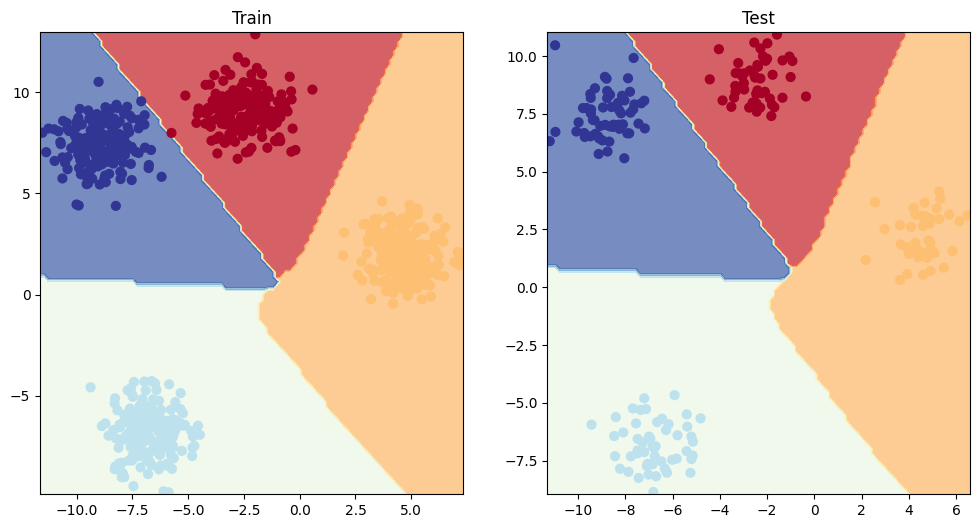

In [11]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1, X_test,y_test)

In [12]:
 # accuracy
import torchmetrics
from torchmetrics import Accuracy

torch_acc=Accuracy(task='multiclass',num_classes=num_classes).to(device)

torch_acc(y_pred,y_test) #(input, target)

tensor(1., device='cuda:0')